# **Ridge / LASSO / Elastic net Regression을 이용한 Odor 분석**

---

In [1]:
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R
package_version(R.version)

[1] ‘4.1.1’


In [3]:
%%R

.libPaths("/content/drive/MyDrive/R packages")
.libPaths()

[1] "/content/drive/MyDrive/R packages" "/usr/local/lib/R/site-library"    
[3] "/usr/lib/R/site-library"           "/usr/lib/R/library"               


## **0. Packages Installation**

In [5]:
%%R

# install.packages("corrplot")                  
# install.packages("PerformanceAnalytics")      # 상관분석 시각화
# install.packages("caret")      
# install.packages("car")            # 다중공산성  
# install.packages("lmtest")         # Durbin-Watson test (잔차의 독립성)
# install.packages("mice")          # M.I 결측치 대체
# install.packages("stringr")
# install.packages("Boruta")
# install.packages("DAAG")          # cv.lm
# install.packages("Metrics")       # RMSE, MAPE
# install.packages("glmnet")        # Ridge LASSO Elastic net

library(glmnet)
library(Metrics)
library(DAAG)
library(Boruta)
library(mice)
library(stringr)
library(lmtest)
library(corrplot)
library(PerformanceAnalytics)
library(caret)
library(car)

R[write to console]: Installing package into ‘/content/drive/MyDrive/R packages’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/glmnet_4.1-2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2184440 bytes (2.1 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[

## **1. Data Preparation**

### **1) Read preprocessed data (log_odo)**

In [ ]:
%%R

odo <- read.csv("drive/MyDrive/PLS_양돈 농가/New_data_preprocessed.csv", fileEncoding = "euc-kr")

### Log + Scaling
log_odo <- as.data.frame(scale(log(odo), center = T, scale = T))
head(log_odo)

          ou       nh3        h2s       mm.1        dms        aca        ppa
1 -1.2249600 -2.043309 -0.3600950 -0.6331603  1.4587731 -1.0749493 -1.4207491
2 -1.2249600 -1.936882  0.3387812  1.0552224  2.8066385  0.7668098  0.9990535
3 -0.8209050 -1.468885 -0.7936594 -0.8879723  2.0631026  0.5917261  0.7867864
4  0.7260806 -1.416330  0.4345010 -0.8879723  1.4646004  0.4284440  0.6354347
5 -1.1919213 -1.263970  0.3446961 -0.8879723 -0.7092863  0.3237269  0.5183596
6 -0.4168700 -1.458160 -1.1504747 -0.8879723 -0.7092863  0.2447109  0.3430590
         iba        bta        iva        vla          ph         pc
1 -1.7334805 -1.6740815 -1.8596790 -1.3374486 -0.64265976 -4.7612230
2  1.2984638  1.1289898  1.3516990  1.2950587  1.08960883  0.8397641
3  0.9772720  1.0331016  1.0695726  1.1290003  0.55236433  0.3658753
4  0.6718374  0.9381735  0.8924571  0.7198563  0.19073125  0.2936154
5  0.5326620  0.7975387  0.8428153  0.6331179  0.21571194  0.3888851
6  0.3998548  0.8066882  0.6910340  0.60

### **2) Data Visualizations**

#### **- 반응변수 (y)**

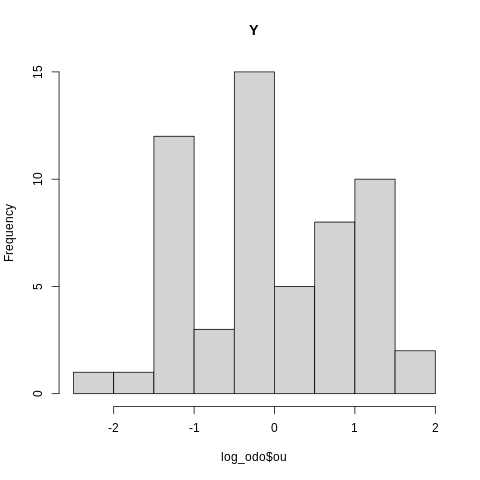

In [ ]:
%%R

hist(log_odo$ou, main="Y")

#### **- Correlation Plot (hitmap)**

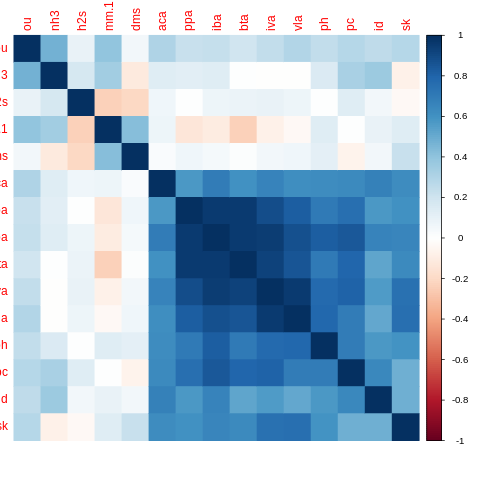

In [ ]:
%%R

log_res <- cor(log_odo, method = "pearson")
corrplot::corrplot(log_res, method = "color", order = "original", tl.pos = "r")


#### **- Correlation Plot**

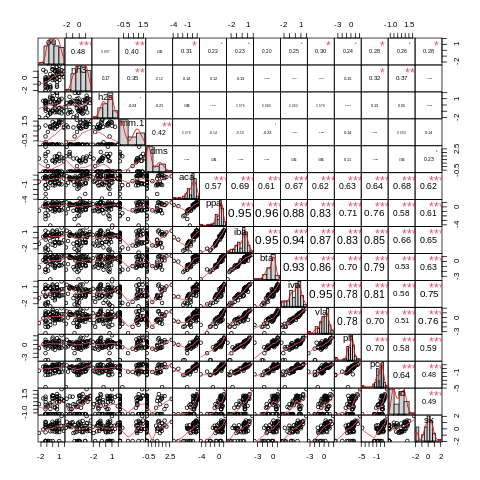

In [ ]:
%%R

chart.Correlation(log_odo, histogram = T, pch = 5)

#### **- Correlation Values**

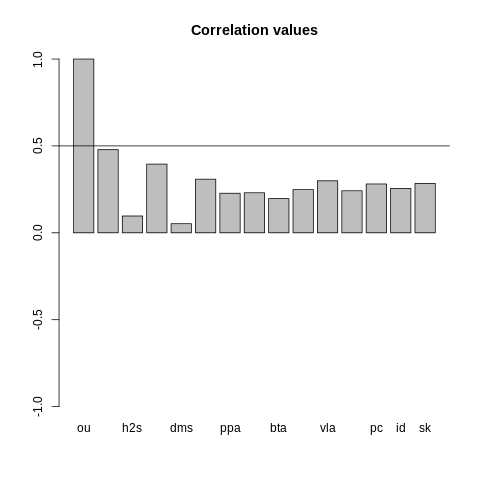

In [ ]:
%%R

# 반응변수
barplot(log_res["ou",], ylim = c(-1,1), main = "Correlation values") ; abline(h = 0.5)

# Total
# print(log_res)

### **3) 다중 공선성 확인**

In [ ]:
%%R

log_mr <- lm(ou ~ ., data = log_odo)

log_VIF <- vif(log_mr)
print(log_VIF)

      nh3       h2s      mm.1       dms       aca       ppa       iba       bta 
 2.590253  1.394278  2.592621  1.538076  2.940215 31.452120 71.838164 33.268410 
      iva       vla        ph        pc        id        sk 
52.146947 19.397979  6.730872  6.965551  3.131767  3.521264 



 5 개 : aca ppa iba bta iva

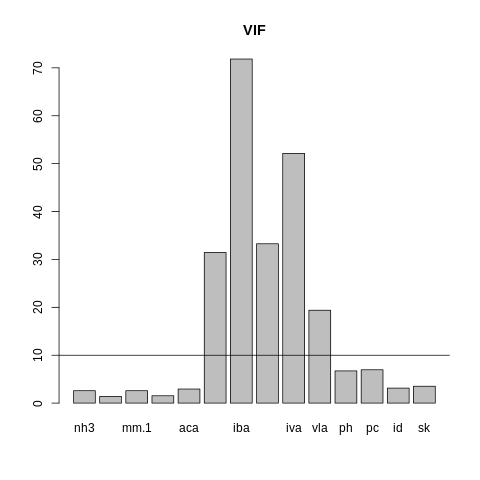

In [ ]:
%%R

barplot(log_VIF, main = "VIF")
abline(h = 10)

cat("\n", sum(log_VIF > 10), "개 :", names(odo[log_VIF > 10]))

## **2. 회귀 가정 확인**

### **1) Dataset 생성**

In [ ]:
%%R

original_data <- read.csv("drive/MyDrive/PLS_양돈 농가/New_data_preprocessed.csv", fileEncoding = "euc-kr")
scale_data <- as.data.frame(scale(original_data, center = T, scale = T))
log_scale_data <- as.data.frame(scale(log(original_data), center = T, scale = T))

### **2) Regression**

In [ ]:
%%R

lmo <- lm(ou ~ ., data = original_data) 
lms <- lm(ou ~ ., data = scale_data) 
lml <- lm(ou ~ ., data = log_scale_data) 

### **3) 잔차 가정 검정**

- **잔차의 등분산성 (Breusch-Pagan test)**

  - $H_0$ : 등분산성이다.  vs  $H_1$ : 등분산성이 아니다.


- **잔차의 독립성 (Durbin-Watson test)**

  - $H_0$ : 잔차는 독립이다.  vs  $H_1$ : 잔차가 자기상관관계가 있다.

  -  DW statistic 값이 2 근처의 값이 나오는 경우 자기상관관계가 없다. (= 독립)

- **잔차의 정규성 (Shapiro-test)**

  - $H_0$ : 모집단은 정규분포를 따른다.   vs   $H_1$ : 모집단은 정규분포를 따르지 않는다.

In [ ]:
# %%R

# # 잔차 plot
# par(mfrow=c(2,2)) 
# plot(lmo)
# plot(lms)
# plot(lml)
# par(mfrow=c(1,1))

In [ ]:
%%R

# Original
print("Original data")
print(bptest(lmo))
print(dwtest(lmo))
lmo_res <- residuals(lmo) ; print(shapiro.test(lmo_res))
print("=======================================================")

# Scale
print("Scale data")
print(bptest(lms))
print(dwtest(lms))
lms_res <- residuals(lms) ; print(shapiro.test(lms_res))
print("=======================================================")

# Log+Scale
print("Log Scale data")
print(bptest(lml))
print(dwtest(lml))
lml_res <- residuals(lml) ; print(shapiro.test(lml_res))

[1] "Original data"

	studentized Breusch-Pagan test

data:  lmo
BP = 7.2243, df = 14, p-value = 0.9257


	Durbin-Watson test

data:  lmo
DW = 1.8645, p-value = 0.1706
alternative hypothesis: true autocorrelation is greater than 0


	Shapiro-Wilk normality test

data:  lmo_res
W = 0.86637, p-value = 1.501e-05

[1] "======================================================="
[1] "Scale data"

	studentized Breusch-Pagan test

data:  lms
BP = 7.2243, df = 14, p-value = 0.9257


	Durbin-Watson test

data:  lms
DW = 1.8645, p-value = 0.1706
alternative hypothesis: true autocorrelation is greater than 0


	Shapiro-Wilk normality test

data:  lms_res
W = 0.86637, p-value = 1.501e-05

[1] "======================================================="
[1] "Log Scale data"

	studentized Breusch-Pagan test

data:  lml
BP = 15.144, df = 14, p-value = 0.3684


	Durbin-Watson test

data:  lml
DW = 1.8273, p-value = 0.1363
alternative hypothesis: true autocorrelation is greater than 0


	Shapiro-Wilk normali

## **3. Penalty Regression**


- **trainContral 함수의 LOOCV 사용.**

- Ridge Reg　:　RSS($\beta$)　+　$\lambda \sum_{j=1}^{p}\beta_j^2$

- Lasso Reg　:　RSS($\beta$)　+　$\lambda \sum_{j=1}^{p}|\beta_j|$

- Elastic Net Reg　:　RSS($\beta$)　+　$\lambda_1 \sum_{j=1}^{p}\beta_j^2　+　\lambda_2 \sum_{j=1}^{p}|\beta_j|$

\
- glmnet　:　 RSS($\beta$)　+　$\lambda[(1-\alpha) \sum_{j=1}^{p}\beta_j^2　+　\alpha \sum_{j=1}^{p}|\beta_j|]$

  - $\alpha=1$ : Lasso
  - $\alpha=0$ : Ridge
  - $0<\alpha<1$ : Elastic Net

  - $\lambda ≥ 0$ 　　if lambda = 0 then It is the same as Normal Regression



### **1) Response and Independent**

In [ ]:
%%R

y <- log_odo$ou
X <- as.matrix(subset(log_odo, select = -c(ou)))

print(head(y))
print(head(X))

[1] -1.2249600 -1.2249600 -0.8209050  0.7260806 -1.1919213 -0.4168700
        nh3        h2s       mm.1        dms        aca        ppa        iba
1 -2.043309 -0.3600950 -0.6331603  1.4587731 -1.0749493 -1.4207491 -1.7334805
2 -1.936882  0.3387812  1.0552224  2.8066385  0.7668098  0.9990535  1.2984638
3 -1.468885 -0.7936594 -0.8879723  2.0631026  0.5917261  0.7867864  0.9772720
4 -1.416330  0.4345010 -0.8879723  1.4646004  0.4284440  0.6354347  0.6718374
5 -1.263970  0.3446961 -0.8879723 -0.7092863  0.3237269  0.5183596  0.5326620
6 -1.458160 -1.1504747 -0.8879723 -0.7092863  0.2447109  0.3430590  0.3998548
         bta        iva        vla          ph         pc          id        sk
1 -1.6740815 -1.8596790 -1.3374486 -0.64265976 -4.7612230 -1.15051078 0.1754534
2  1.1289898  1.3516990  1.2950587  1.08960883  0.8397641  0.89726697 1.1256139
3  1.0331016  1.0695726  1.1290003  0.55236433  0.3658753 -0.05408986 0.3798852
4  0.9381735  0.8924571  0.7198563  0.19073125  0.2936154  1.203

### **2) Ridge LOO Regression**

#### **- Hyperparameter Range**

In [ ]:
%%R 

rid_Grid <- expand.grid(.alpha = 0,
                         .lambda = seq(0.01, 1, 0.01))

#### **- Model training (rid_model)**

In [ ]:
%%R

control_ridge <- trainControl(
    method = "LOOCV",
    repeats = 1
)

In [ ]:
%%R

rid_model <- train(
    ou ~ .,
    data = log_odo,
    method = "glmnet",
    tuneGrid = rid_Grid,
    metric = "MSE",
    trControl = control_ridge
)

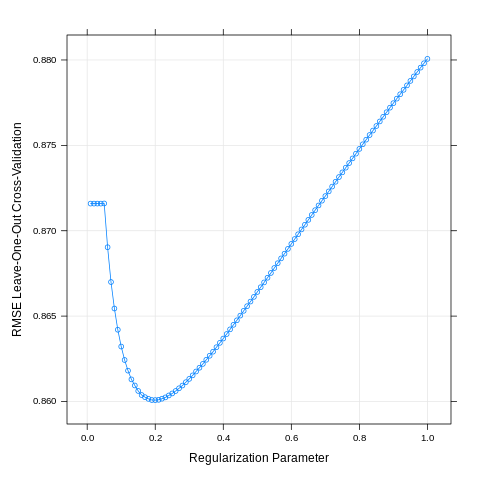

In [ ]:
%%R

plot(rid_model)

In [ ]:
%%R

names(rid_model)

 [1] "method"       "modelInfo"    "modelType"    "results"      "pred"        
 [6] "bestTune"     "call"         "dots"         "metric"       "control"     
[11] "finalModel"   "preProcess"   "trainingData" "resample"     "resampledCM" 
[16] "perfNames"    "maximize"     "yLimits"      "times"        "levels"      
[21] "terms"        "coefnames"    "xlevels"     


In [ ]:
%%R

### 최적의 lambda
which_best_rid_parameter <- as.numeric(rownames(rid_model$bestTune))
best_rid_parameter <- rid_model$bestTune
best_rid_parameter

   alpha lambda
20     0    0.2


In [ ]:
%%R

### 회귀 계수

rid_beta <- rid_model$finalMode$beta[, which_best_rid_parameter]
round(rid_beta, 4)

   nh3    h2s   mm.1    dms    aca    ppa    iba    bta    iva    vla     ph 
0.0057 0.0012 0.0048 0.0006 0.0035 0.0025 0.0025 0.0021 0.0028 0.0034 0.0027 
    pc     id     sk 
0.0032 0.0029 0.0032 


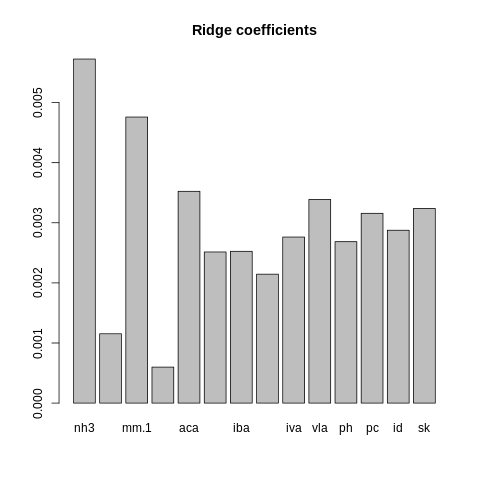

In [ ]:
%%R

barplot(rid_beta, main = "Ridge coefficients")

#### **- New Data set(rid_odo)**

In [ ]:
%%R

th = 0.003

sel_rid <- rid_beta[abs(rid_beta) > th]

cat("선택된 변수 : ", names(sel_rid), "(", length(sel_rid), "개)", "\n")

del_rid <- rid_beta[rid_beta <= th]
cat("제거된 변수 : ", names(del_rid))

선택된 변수 :  nh3 mm.1 aca vla pc sk ( 6 개) 
제거된 변수 :  h2s dms ppa iba bta iva ph id

In [ ]:
%%R

rid_odo <- cbind(log_odo["ou"], log_odo[names(sel_rid)])
head(rid_odo)

          ou       nh3       mm.1        aca        vla         pc        sk
1 -1.2249600 -2.043309 -0.6331603 -1.0749493 -1.3374486 -4.7612230 0.1754534
2 -1.2249600 -1.936882  1.0552224  0.7668098  1.2950587  0.8397641 1.1256139
3 -0.8209050 -1.468885 -0.8879723  0.5917261  1.1290003  0.3658753 0.3798852
4  0.7260806 -1.416330 -0.8879723  0.4284440  0.7198563  0.2936154 0.8561538
5 -1.1919213 -1.263970 -0.8879723  0.3237269  0.6331179  0.3888851 0.6289272
6 -0.4168700 -1.458160 -0.8879723  0.2447109  0.6049416  0.1798871 0.4819419


### **3) LASSO LOO Regression**

#### **- Hyperparameter Range**

In [ ]:
%%R 

las_Grid <- expand.grid(.alpha = 1,
                        .lambda = seq(0.01, 1, 0.01))


#### **- Model training (rid_model)**

In [ ]:
%%R

control_lasso <- trainControl(
    method = "LOOCV",
    repeats = 1
)

In [ ]:
%%R

las_model <- train(
    ou ~ .,
    data = log_odo,
    method = "glmnet",
    tuneGrid = las_Grid,
    metric = "MSE",
    trControl = control_ridge
)

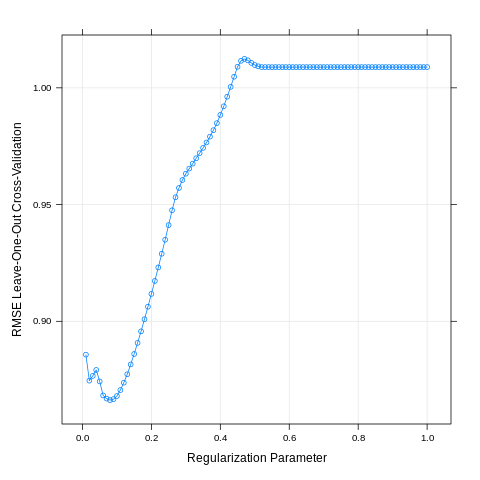

In [ ]:
%%R

plot(las_model)

In [ ]:
%%R

names(las_model)

 [1] "method"       "modelInfo"    "modelType"    "results"      "pred"        
 [6] "bestTune"     "call"         "dots"         "metric"       "control"     
[11] "finalModel"   "preProcess"   "trainingData" "resample"     "resampledCM" 
[16] "perfNames"    "maximize"     "yLimits"      "times"        "levels"      
[21] "terms"        "coefnames"    "xlevels"     


In [ ]:
%%R

### 최적의 lambda
which_best_las_parameter <- as.numeric(rownames(las_model$bestTune))
best_las_parameter <- las_model$bestTune
best_las_parameter

  alpha lambda
8     1   0.08


In [ ]:
%%R

### 회귀 계수

las_beta <- las_model$finalMode$beta[, which_best_las_parameter]
round(las_beta, 4)

   nh3    h2s   mm.1    dms    aca    ppa    iba    bta    iva    vla     ph 
0.2022 0.0000 0.0778 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0531 0.0000 
    pc     id     sk 
0.0000 0.0000 0.0000 


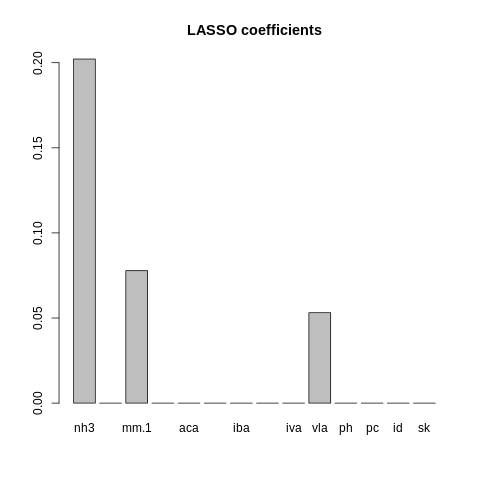

In [ ]:
%%R

barplot(las_beta, main = "LASSO coefficients")

#### **- New Data set(las_odo)**

In [ ]:
%%R

th = 0

sel_las <- las_beta[abs(las_beta) > th]

cat("선택된 변수 : ", names(sel_las), "(", length(sel_las), "개)", "\n")

del_las <- las_beta[las_beta <= th]
cat("제거된 변수 : ", names(del_las))

선택된 변수 :  nh3 mm.1 vla ( 3 개) 
제거된 변수 :  h2s dms aca ppa iba bta iva ph pc id sk

In [ ]:
%%R

las_odo <- cbind(log_odo["ou"], log_odo[names(sel_las)])
head(las_odo)

          ou       nh3       mm.1        vla
1 -1.2249600 -2.043309 -0.6331603 -1.3374486
2 -1.2249600 -1.936882  1.0552224  1.2950587
3 -0.8209050 -1.468885 -0.8879723  1.1290003
4  0.7260806 -1.416330 -0.8879723  0.7198563
5 -1.1919213 -1.263970 -0.8879723  0.6331179
6 -0.4168700 -1.458160 -0.8879723  0.6049416


### **4) Elastic Net LOO Regression**

#### **- Hyperparameter Range**

In [ ]:
%%R 

elas_Grid <- expand.grid(.alpha = seq(0.1, 0.9, 0.1),
                         .lambda = seq(0.01, 1, 0.01))



#### **- Model training (rid_model)**

In [ ]:
%%R

control_elas <- trainControl(
    method = "LOOCV",
    repeats = 1
)

In [ ]:
%%R

elas_model <- train(
    ou ~ .,
    data = log_odo,
    method = "glmnet",
    tuneGrid = elas_Grid,
    metric = "MSE",
    trControl = control_elas
)

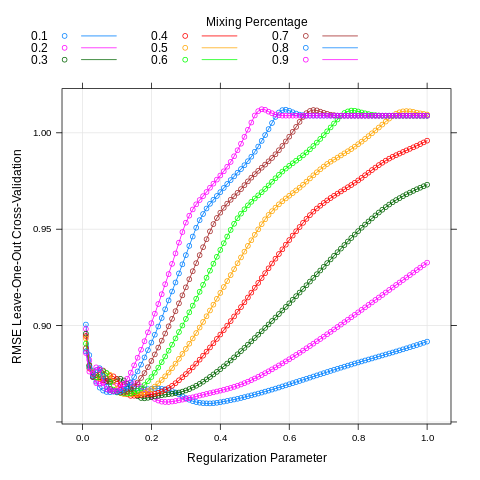

In [ ]:
%%R

plot(elas_model)

In [ ]:
%%R

names(elas_model)

 [1] "method"       "modelInfo"    "modelType"    "results"      "pred"        
 [6] "bestTune"     "call"         "dots"         "metric"       "control"     
[11] "finalModel"   "preProcess"   "trainingData" "resample"     "resampledCM" 
[16] "perfNames"    "maximize"     "yLimits"      "times"        "levels"      
[21] "terms"        "coefnames"    "xlevels"     


In [ ]:
%%R

### 최적의 lambda
which_best_elas_parameter <- as.numeric(rownames(elas_model$bestTune))
best_elas_parameter <- elas_model$bestTune
best_elas_parameter

   alpha lambda
37   0.1   0.37


In [ ]:
%%R

### 회귀 계수

elas_beta <- elas_model$finalMode$beta[, which_best_elas_parameter]
round(elas_beta, 4)

    nh3     h2s    mm.1     dms     aca     ppa     iba     bta     iva     vla 
 0.3374  0.0551  0.2464 -0.0096  0.0963  0.0000  0.0000  0.0203  0.0000  0.1881 
     ph      pc      id      sk 
-0.0657  0.0000 -0.0505  0.0951 


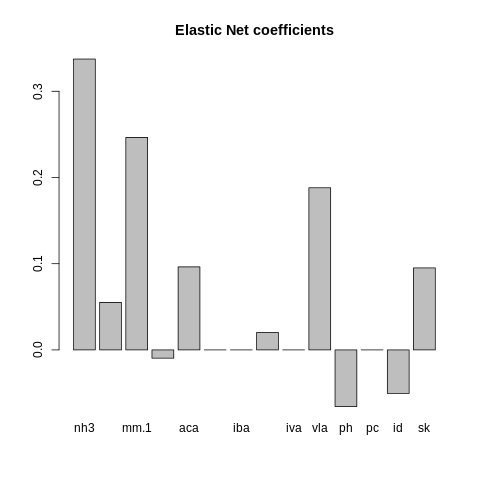

In [ ]:
%%R

barplot(elas_beta, main = "Elastic Net coefficients") 

#### **- New Data set(elas_odo)**

In [ ]:
%%R

th = 0.1

sel_elas <- elas_beta[abs(elas_beta) > th]

cat("선택된 변수 : ", names(sel_elas), "(", length(sel_elas), "개)", "\n")

del_elas <- elas_beta[elas_beta <= th]
cat("제거된 변수 : ", names(del_elas))

선택된 변수 :  nh3 mm.1 vla ( 3 개) 
제거된 변수 :  h2s dms aca ppa iba bta iva ph pc id sk

In [ ]:
%%R

elas_odo <- cbind(log_odo["ou"], log_odo[names(sel_elas)])
head(elas_odo)

          ou       nh3       mm.1        vla
1 -1.2249600 -2.043309 -0.6331603 -1.3374486
2 -1.2249600 -1.936882  1.0552224  1.2950587
3 -0.8209050 -1.468885 -0.8879723  1.1290003
4  0.7260806 -1.416330 -0.8879723  0.7198563
5 -1.1919213 -1.263970 -0.8879723  0.6331179
6 -0.4168700 -1.458160 -0.8879723  0.6049416


### **5) 잔차 가정 검정**

In [ ]:
%%R

lmr <- lm(ou ~ ., data = rid_odo) 
lml <- lm(ou ~ ., data = las_odo) 
lme <- lm(ou ~ ., data = elas_odo) 

In [ ]:
%%R

# Ridge
print("Ridge data")
print(bptest(lmr))
print(dwtest(lmr))
lmr_res <- residuals(lmr) ; print(shapiro.test(lmr_res))
print("=======================================================")

# Lasso
print("Lasso data")
print(bptest(lml))
print(dwtest(lml))
lml_res <- residuals(lml) ; print(shapiro.test(lml_res))
print("=======================================================")

# Elastic Net
print("Elastic Net")
print(bptest(lme))
print(dwtest(lme))
lme_res <- residuals(lme) ; print(shapiro.test(lme_res))

[1] "Ridge data"

	studentized Breusch-Pagan test

data:  lmr
BP = 3.6137, df = 6, p-value = 0.7288


	Durbin-Watson test

data:  lmr
DW = 1.805, p-value = 0.1667
alternative hypothesis: true autocorrelation is greater than 0


	Shapiro-Wilk normality test

data:  lmr_res
W = 0.97732, p-value = 0.3586

[1] "======================================================="
[1] "Lasso data"

	studentized Breusch-Pagan test

data:  lml
BP = 0.37818, df = 3, p-value = 0.9447


	Durbin-Watson test

data:  lml
DW = 1.85, p-value = 0.2299
alternative hypothesis: true autocorrelation is greater than 0


	Shapiro-Wilk normality test

data:  lml_res
W = 0.97807, p-value = 0.3859

[1] "======================================================="
[1] "Elastic Net"

	studentized Breusch-Pagan test

data:  lme
BP = 0.37818, df = 3, p-value = 0.9447


	Durbin-Watson test

data:  lme
DW = 1.85, p-value = 0.2299
alternative hypothesis: true autocorrelation is greater than 0


	Shapiro-Wilk normality test

data:  lm

### **6) VIF**

In [ ]:
%%R

# Ridge
print("Ridge data")
Rid_VIF <- vif(lmr)
print(Rid_VIF)
print("=======================================================")

# Lasso
print("Lasso data")
Las_VIF <- vif(lml)
print(Las_VIF)
print("=======================================================")

# Elastic Net
print("Elastic Net data")
Elas_VIF <- vif(lme)
print(Elas_VIF)

[1] "Ridge data"
     nh3     mm.1      aca      vla       pc       sk 
1.511452 1.282348 2.164211 3.811894 2.902610 3.016329 
[1] "======================================================="
[1] "Lasso data"
     nh3     mm.1      vla 
1.136436 1.137880 1.001389 
[1] "======================================================="
[1] "Elastic Net data"
     nh3     mm.1      vla 
1.136436 1.137880 1.001389 


## **4. Results**

### **1) Validation**

In [ ]:
%%R

head(rid_model$results)

  alpha lambda      RMSE  Rsquared       MAE
1     0   0.01 0.8715886 0.2455441 0.6910189
2     0   0.02 0.8715886 0.2455441 0.6910189
3     0   0.03 0.8715886 0.2455441 0.6910189
4     0   0.04 0.8715886 0.2455441 0.6910189
5     0   0.05 0.8715962 0.2449693 0.6901084
6     0   0.06 0.8690339 0.2464157 0.6855472


#### **- R-Squared**

In [ ]:
%%R

rid_r2 <- subset(rid_model$results, rid_model$results[,"lambda"] == best_rid_parameter[, "lambda"])$Rsquared
las_r2 <- subset(las_model$results, las_model$results[,"lambda"] == best_las_parameter[, "lambda"])$Rsquared
elas_r2 <- subset(elas_model$results, elas_model$results[,"alpha"] == best_elas_parameter[, "alpha"] & 
                                      elas_model$results[,"lambda"] == best_elas_parameter[, "lambda"])$Rsquared

cat("Ridge R2 :", round(rid_r2 ,3), "\n")
cat("LASSO R2 :", round(las_r2 ,3), "\n")
cat("Elastic R2 :", round(elas_r2 ,3))

Ridge R2 : 0.249 
LASSO R2 : 0.236 
Elastic R2 : 0.25

#### **- RMSE**

In [ ]:
%%R

rid_rmse <- subset(rid_model$results, rid_model$results[,"lambda"] == best_rid_parameter[, "lambda"])$RMSE
las_rmse <- subset(las_model$results, las_model$results[,"lambda"] == best_las_parameter[, "lambda"])$RMSE
elas_rmse <- subset(elas_model$results, elas_model$results[,"alpha"] == best_elas_parameter[, "alpha"] & 
                                      elas_model$results[,"lambda"] == best_elas_parameter[, "lambda"])$RMSE

cat("Ridge rmse :", round(rid_rmse ,3), "\n")
cat("LASSO rmse :", round(las_rmse ,3), "\n")
cat("Elastic rmse :", round(elas_rmse ,3))

Ridge rmse : 0.86 
LASSO rmse : 0.866 
Elastic rmse : 0.86

#### **- MAE**

In [ ]:
%%R

rid_mae <- subset(rid_model$results, rid_model$results[,"lambda"] == best_rid_parameter[, "lambda"])$MAE
las_mae <- subset(las_model$results, las_model$results[,"lambda"] == best_las_parameter[, "lambda"])$MAE
elas_mae <- subset(elas_model$results, elas_model$results[,"alpha"] == best_elas_parameter[, "alpha"] & 
                                      elas_model$results[,"lambda"] == best_elas_parameter[, "lambda"])$MAE

cat("Ridge mae :", round(rid_mae ,3), "\n")
cat("LASSO mae :", round(las_mae ,3), "\n")
cat("Elastic mae :", round(elas_mae ,3))

Ridge mae : 0.675 
LASSO mae : 0.682 
Elastic mae : 0.676

#### **- Pred plot**

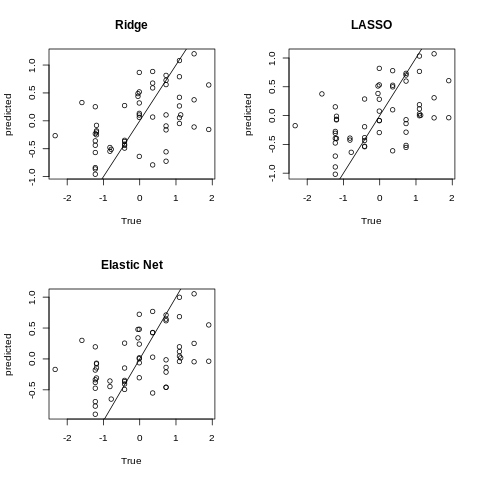

In [ ]:
%%R

rid_pred <- subset(rid_model$pred, rid_model$pred[,"lambda"] == best_rid_parameter[, "lambda"])$pred
las_pred <- subset(las_model$pred, las_model$pred[,"lambda"] == best_las_parameter[, "lambda"])$pred
elas_pred <- subset(elas_model$pred, elas_model$pred[,"alpha"] == best_elas_parameter[, "alpha"] &
                                     elas_model$pred[,"lambda"] == best_elas_parameter[, "lambda"])$pred

par(mfrow = c(2,2))
plot(log_odo$ou, rid_pred, main = "Ridge", xlab = "True", ylab = "predicted") ; abline(a = 0 , b = 1)
plot(log_odo$ou, las_pred, main = "LASSO", xlab = "True", ylab = "predicted") ; abline(a = 0 , b = 1)
plot(log_odo$ou, elas_pred, main = "Elastic Net", xlab = "True", ylab = "predicted") ; abline(a = 0 , b = 1)
par(mfrow = c(1,1))

### **2) Fitted**

#### **- R-Squared**

#### **- RMSE**

#### **- MAE**

#### **- Pred plot**

### **3) 결과 정리**

In [ ]:
%%R

R2 <- as.data.frame(round(c(rid_r2, las_r2, elas_r2), 3))
RMSE <- as.data.frame(round(c(rid_rmse, las_rmse, elas_rmse), 3))
MAE <- as.data.frame(round(c(rid_mae, las_mae, elas_mae), 3))

Log_LRE_valid_results <- cbind(R2, RMSE, MAE)
colnames(Log_LRE_valid_results) <- c("R2", "RMSE", "MAE")
rownames(Log_LRE_valid_results) <- c("Ridge", "LASSO", "Elastic Net")
Log_LRE_valid_results

               R2  RMSE   MAE
Ridge       0.249 0.860 0.675
LASSO       0.236 0.866 0.682
Elastic Net 0.250 0.860 0.676


In [ ]:
%%R

### 아직 준비 안됨!!

# FR2 <- 
# FRMSE <- 
# FMAE <- 

# Log_LRE_fitted_results <- cbind(FR2, FRMSE, FMAE)
Log_LRE_fitted_results <- as.data.frame(matrix(-99999999*9, 3,3))
colnames(Log_LRE_fitted_results) <- c("FR2", "FRMSE", "FMAE")
rownames(Log_LRE_fitted_results) <- c("Ridge", "LASSO", "Elastic Net")
Log_LRE_fitted_results 

               FR2  FRMSE   FMAE
Ridge       -9e+08 -9e+08 -9e+08
LASSO       -9e+08 -9e+08 -9e+08
Elastic Net -9e+08 -9e+08 -9e+08


In [ ]:
%%R

Results <- cbind(Log_LRE_valid_results , Log_LRE_fitted_results )
# Results

write.csv(Results, file = "drive/MyDrive/PLS_양돈 농가/(Results) Log_LRE.csv")

check_Results <- read.csv("drive/MyDrive/PLS_양돈 농가/(Results) Log_LRE.csv", fileEncoding = "euc-kr", row.names = 1)
check_Results

               R2  RMSE   MAE        FR2      FRMSE       FMAE
Ridge       0.249 0.860 0.675 -899999991 -899999991 -899999991
LASSO       0.236 0.866 0.682 -899999991 -899999991 -899999991
Elastic Net 0.250 0.860 0.676 -899999991 -899999991 -899999991
